## Lógica Computacional: 25/26
---
## TP1 - Ex1

$Grupo$ $05$ 

*   Vasco Ferreira Leite (A108399)
*   Gustavo da Silva Faria (A108575)
*   Afonso Henrique Cerqueira Leal (A108472)
---

### Descrição do problema

Este problema usa optimização MIP (“Mixed Integer Programming” (OrTools) e representação por  Grafos ( NetworkX)).

1. Para um distribuidor de encomendas o seu território está organizados em pontos (“nodes”) de fornecimento (“sources”), pontos de passagem  e pontos de entrega (“sinks”) ligados por vias de comunicação (“edges”) bidirecionais cada uma das quais associada uma capacidade em termos do número de veículos de transporte que suporta.
2. Os items distribuidos estão organizados em “pacotes” de três tipos “standard” : uma unidade, duas unidades e cinco unidades. Os pacotes são transportados em veículos todos com a capacidade de 10 unidades. Cada ponto de entrega tem um limite no número total de unidades que tem em “stock” e um limite no número de veículos que dispõe.
3. Cada encomenda é definida por o identificador do ponto de entrega e pelo número de pacotes, de cada um dos tipos, que devem ser entregues nesse ponto.
4. O objetivo do problema é decidir, a partir de uma encomenda e com um mínimo no número de veículos:

        Em cada ponto de entrega,  se estará envolvido no fornecimento de unidades que essa encomenda requer sem violar os limites do seu “stock”.

        Em cada ponto de entrega,   como empacotar as unidades disponíveis, de acordo com a encomenda”,  e como as distribuir por veículos,

        Em cada veículo, qual o percurso a seguir até  ao ponto de entrega; para cada via ao longo de cada percurso, o total de veículos não pode exceder a capacidade dessa via.

### **Resolução do problema**

##### **Variáveis**

*   `G`: Grafo direcional (bidirecional)
*   `encomenda`: Dicionário que contém o destino da encomenda e os pacotes respetivos
*   `capacidade_veiculo`: Valor com a capacidade máxima de unidades por veículo
*   `tipos_pacotes`: Dicionário com os tipos de pacote (1,2 ou 5)
*   `sources, sinks, passagem`: listas com os respetivos nós (S, D, H & P)

##### **Importação de Bibliotecas**

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

*   `NetworkX`: Para modelar e manipular o grafo da rede de distribuição
*   `Matplotlib`: Para visualização gráfica da rede
*   `OR-Tools`: Para resolver o problema de otimização MIP

# **Funções**

## Função criar_rede

Esta função é responsável por construir a rede de distribuição.
Para isso, são criados pontos (“nodes”) de fornecimento (“sources”), pontos de passagem  e pontos de entrega (“sinks”) ligados por vias de comunicação (“edges”) . Às sources estão atríbuidas um stock (unidades disponíveis) e um número máximo de veículos. As vias uma capacidade são bidirecionais e está lhes atribuído uma capacidade que representa o número máximo de veículos.

In [2]:
def criar_rede():
    """Cria a rede de distribuição"""
    G = nx.DiGraph()
    
    # Sources
    G.add_node('S1', type='source', color='green', stock=40, veiculos=8)
    G.add_node('S2', type='source', color='green', stock=45, veiculos=9)
    
    # Pontos de passagem
    G.add_node('H1', type='passagem', color='lightblue')
    G.add_node('H2', type='passagem', color='lightblue')
    G.add_node('P1', type='passagem', color='skyblue')
    G.add_node('P2', type='passagem', color='skyblue')
   
    # Destinos
    G.add_node('D1', type='sink', color='red')
    G.add_node('D2', type='sink', color='red')
    G.add_node('D3', type='sink', color='red')
    G.add_node('D4', type='sink', color='red')
   
    # Vias (origem, destino, capacidade)
    vias = [
        ('S1', 'H1', 12), ('S1', 'H2', 9),
        ('S2', 'H1', 10), ('S2', 'P2', 8),
        ('H1', 'H2', 9), ('H1', 'P1', 8), ('H1', 'P2', 9), ('H1', 'D1', 5), ('H1', 'D3', 6), 
        ('H2', 'P1', 6), ('H2', 'D2', 4),
        ('P1', 'P2', 6), ('P1', 'D1', 7), ('P1', 'D2', 6),
        ('P2', 'D2', 7), ('P2', 'D3', 8), ('P2', 'D4', 9), 
        ('D1', 'D2', 4), ('D3', 'D4', 5),
    ]
    
    for orig, dest, cap in vias:
        G.add_edge(orig, dest, capacity=cap)
        G.add_edge(dest, orig, capacity=cap)
    
    return G

## Função visualizar_rede

Esta função é responsável por organizar visualmente os nós (sources em cima, sinks em baixo) e usa cores distintas para distinguir o tipo dos mesmos. As vias têm as capacidades das mesmas como rótulo. Por fim, a função apresenta um grafo que representa toda a rede.

In [3]:
def visualizar_rede(G):
    """Visualiza a rede de distribuição"""
    sources = [n for n in G.nodes if G.nodes[n]['type'] == 'source']
    sinks = [n for n in G.nodes if G.nodes[n]['type'] == 'sink']
    passagem = [n for n in G.nodes if G.nodes[n]['type'] == 'passagem']
        
    pos = {}
    for i, node in enumerate(sources):
        pos[node] = (i * 2, 3)
    
    hubs = [n for n in passagem if n.startswith('H')]
    intermedios = [n for n in passagem if n.startswith('P')]
    
    for i, node in enumerate(hubs):
        pos[node] = (i * 2.5 + 0.5, 2)
    for i, node in enumerate(intermedios):
        pos[node] = (i * 2 + 1, 1)
    for i, node in enumerate(sinks):
        pos[node] = (i * 1.5 + 0.5, 0)
    
    plt.figure(figsize=(14, 10))
  
    node_colors = [G.nodes[n]['color'] for n in G.nodes]
    
    nx.draw_networkx_edges(G, pos, width=1, alpha=1, 
                          edge_color='black', arrows=True, arrowsize=15)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=1200, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    
    edge_labels = {}
    edges_processed = set()
    for u, v in G.edges():
        if (v, u) not in edges_processed:
            edge_labels[(u, v)] = G[u][v]['capacity']
            edges_processed.add((u, v))
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels, alpha=1)
    
    plt.title("Rede de Distribuição", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


## Função resolver_encomenda

A função recebe uma encomenda contendo o destino e os pacotes correspondentes (tipos e quantidades). O solver irá calcular o número mínimo de veículos necessários para completar essa encomenda, respeitando várias restrições do problema, como a capacidade dos veículos, o stock disponível em cada armazém (source), o número máximo de veículos por armazém e as capacidades das vias. Após a resolução, a função formaliza a solução, apresentando um feedback sobre o resultado e indicando se todas as restrições foram cumpridas.

In [4]:
def resolver_encomenda(G, encomenda, capacidade_veiculo=10, tipos_pacotes={1: 1, 2: 2, 5: 5}):
    """Resolve o problema de otimização para uma encomenda"""
    destino = encomenda['destino']
    pacotes_pedidos = encomenda['pacotes']
    
    unidades_necessarias = sum(tipos_pacotes[tipo] * qtd 
                               for tipo, qtd in pacotes_pedidos.items())
    
    print(f"DESTINO: {destino} \nPacotes: {pacotes_pedidos} | Total de Unidades: {unidades_necessarias}")
    
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        return None
    
    sources = [n for n in G.nodes if G.nodes[n]['type'] == 'source']
    
    # Variáveis
    x = {} # qtd de pacotes tipo do source
    for s in sources:
        for tipo in tipos_pacotes:
            x[(s, tipo)] = solver.IntVar(0, solver.infinity(), f'x_{s}_{tipo}')
    
    y = {}  # número de veículos do source
    for s in sources:
        y[s] = solver.IntVar(0, solver.infinity(), f'y_{s}')
    
    z = {}  # se source usado, 0 caso contrário
    for s in sources:
        z[s] = solver.BoolVar(f'z_{s}')
    
    # Restrições
    # Atender demanda
    for tipo, qtd_pedida in pacotes_pedidos.items():
        solver.Add(sum(x[(s, tipo)] for s in sources) == qtd_pedida)
    
    # Capacidade dos veículos (10 unidades)
    for s in sources:
        unidades_source = sum(tipos_pacotes[tipo] * x[(s, tipo)] 
                             for tipo in tipos_pacotes)
        solver.Add(unidades_source <= capacidade_veiculo * y[s])
    
    # Limite de stock
    for s in sources:
        unidades_source = sum(tipos_pacotes[tipo] * x[(s, tipo)] 
                             for tipo in tipos_pacotes)
        solver.Add(unidades_source <= G.nodes[s]['stock'])
    
    # Limite de veículos
    for s in sources:
        solver.Add(y[s] <= G.nodes[s]['veiculos'])
    
    # Ligar z a y
    for s in sources:
        solver.Add(y[s] <= 1000 * z[s])
    
    # Capacidade das vias
    for s in sources:
        if nx.has_path(G, s, destino):
            caminho = nx.shortest_path(G, s, destino)
            for i in range(len(caminho) - 1):
                edge_cap = G[caminho[i]][caminho[i+1]]['capacity']
                solver.Add(y[s] <= edge_cap)
    
    solver.Minimize(sum(y[s] for s in sources))
    
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        print(f"\nSolução ótima: {int(solver.Objective().Value())} veículos\n")

        print("1. SOURCES ENVOLVIDOS:")
        for s in sources:
            if z[s].solution_value() > 0.5:
                unidades = sum(tipos_pacotes[tipo] * int(x[(s, tipo)].solution_value()) 
                              for tipo in tipos_pacotes)
                stock_disp = G.nodes[s]['stock']
                print(f"   [{s}]: {unidades}/{stock_disp} unidades (restante: {stock_disp - unidades})")

        print("\n2. EMPACOTAMENTO E ROTAS POR VEÍCULO:")
        veiculo_id = 1
        for s in sources:
            if z[s].solution_value() > 0.5:
                num_veiculos = int(y[s].solution_value())
                
                pacotes = []
                for tipo in tipos_pacotes:
                    qtd = int(x[(s, tipo)].solution_value())
                    pacotes.extend([tipo] * qtd)
                
                # Distribuir pacotes pelos veículos
                pacotes_por_veiculo = [[] for _ in range(num_veiculos)]
                unidades_por_veiculo = [0] * num_veiculos
                
                for pacote in sorted(pacotes, reverse=True):
                    idx = unidades_por_veiculo.index(min(unidades_por_veiculo))
                    pacotes_por_veiculo[idx].append(pacote)
                    unidades_por_veiculo[idx] += tipos_pacotes[pacote]
                
                for i in range(num_veiculos):
                    print(f"   V{veiculo_id} [{s}]: {pacotes_por_veiculo[i]} = {unidades_por_veiculo[i]} unidades")
                    veiculo_id += 1
        
        # Rotas e capacidades
        print("\n3. ROTAS E CAPACIDADE DAS VIAS:")
        for s in sources:
            if z[s].solution_value() > 0.5:
                num_veiculos = int(y[s].solution_value())
                caminho = nx.shortest_path(G, s, destino)
                
                print(f"{' -> '.join(caminho)} ({num_veiculos} veículos)")
                
                for i in range(len(caminho) - 1):
                    cap = G[caminho[i]][caminho[i+1]]['capacity']
                    ok = "✓" if num_veiculos <= cap else "✗"
                    print(f"      {caminho[i]}->{caminho[i+1]}: {num_veiculos}/{cap} {ok}")
        
        print("\n")
        return True
    else:
        print("\n✗ Sem solução ótima (capacidade/stock insuficiente)\n")
        return None


#### **Exemplo de problemas**
*   #### Problema 1 (12 unidades)

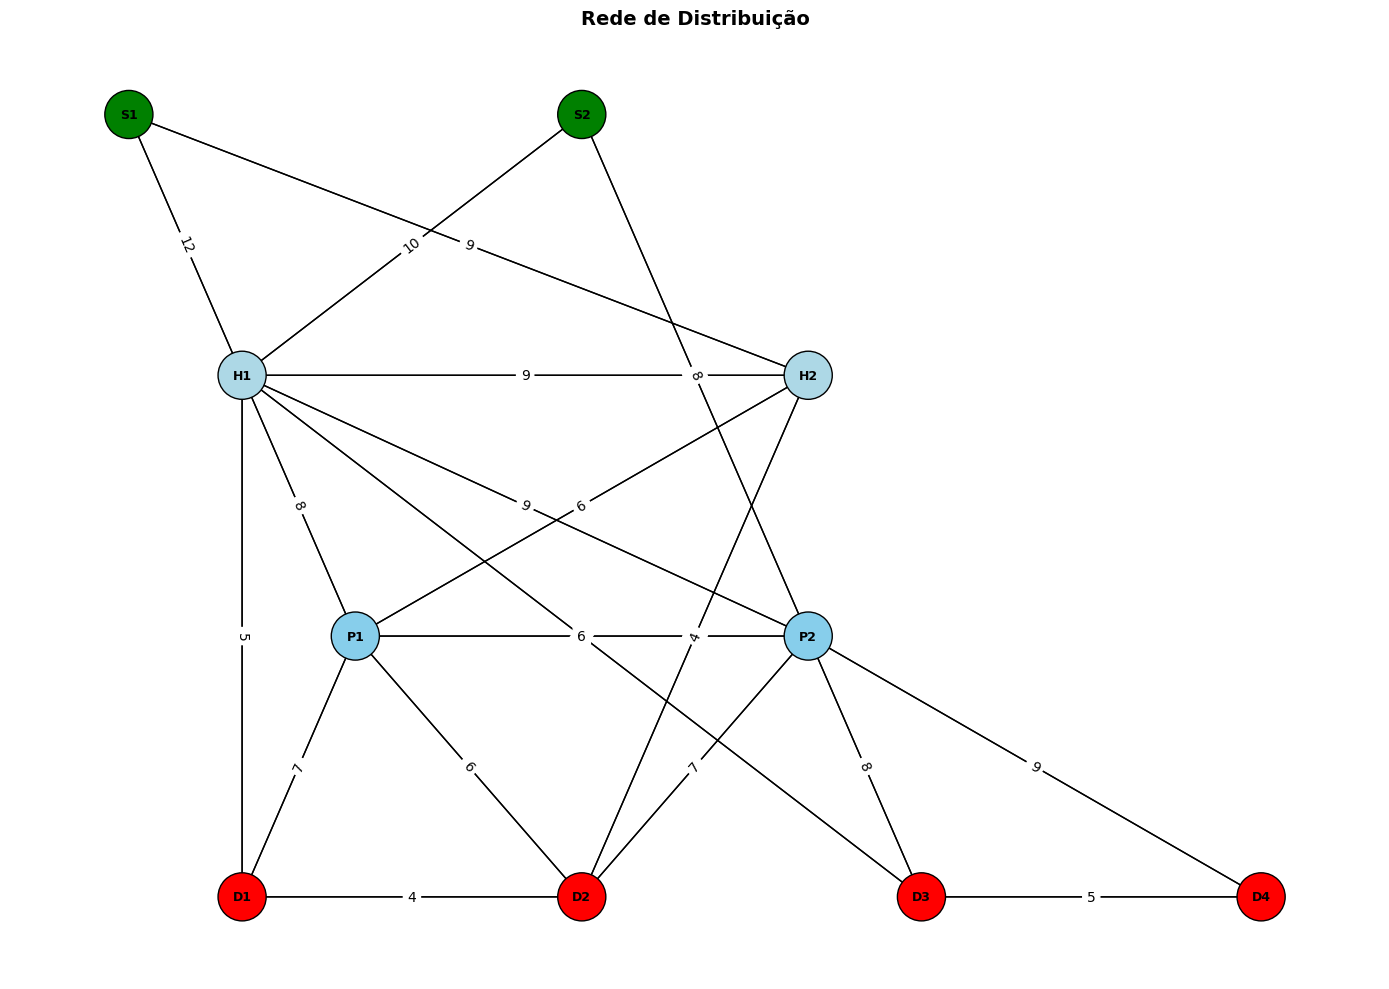

DESTINO: D1 
Pacotes: {1: 3, 2: 2, 5: 1} | Total de Unidades: 12

Solução ótima: 2 veículos

1. SOURCES ENVOLVIDOS:
   [S1]: 0/40 unidades (restante: 40)
   [S2]: 12/45 unidades (restante: 33)

2. EMPACOTAMENTO E ROTAS POR VEÍCULO:
   V1 [S2]: [5, 1] = 6 unidades
   V2 [S2]: [2, 2, 1, 1] = 6 unidades

3. ROTAS E CAPACIDADE DAS VIAS:
S1 -> H1 -> D1 (0 veículos)
      S1->H1: 0/12 ✓
      H1->D1: 0/5 ✓
S2 -> H1 -> D1 (2 veículos)
      S2->H1: 2/10 ✓
      H1->D1: 2/5 ✓




In [5]:
if __name__ == "__main__":
    G = criar_rede()
    visualizar_rede(G)

    encomenda1 = {
        'destino': 'D1',
        'pacotes': {1: 3, 2: 2, 5: 1}  # 12 unidades
    }
    resolver_encomenda(G, encomenda1)

#### **Exemplo de problemas**
*   #### Problema 2 (21 unidades)

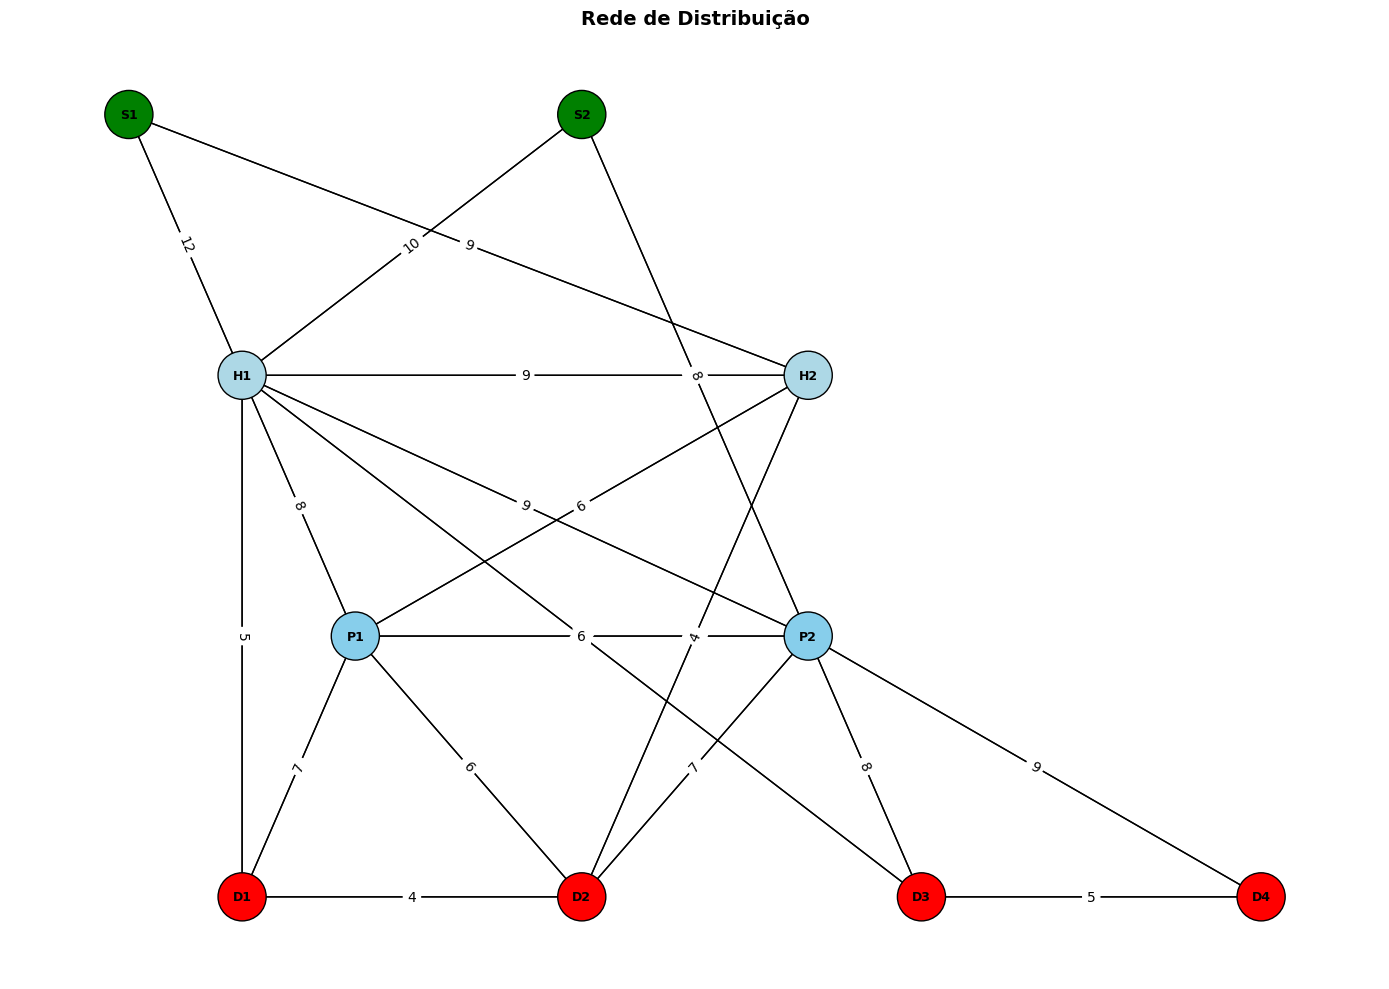

DESTINO: D4 
Pacotes: {1: 5, 2: 3, 5: 2} | Total de Unidades: 21

Solução ótima: 3 veículos

1. SOURCES ENVOLVIDOS:
   [S1]: 11/40 unidades (restante: 29)
   [S2]: 10/45 unidades (restante: 35)

2. EMPACOTAMENTO E ROTAS POR VEÍCULO:
   V1 [S1]: [2, 2, 1, 1] = 6 unidades
   V2 [S1]: [2, 1, 1, 1] = 5 unidades
   V3 [S2]: [5, 5] = 10 unidades

3. ROTAS E CAPACIDADE DAS VIAS:
S1 -> H1 -> P2 -> D4 (2 veículos)
      S1->H1: 2/12 ✓
      H1->P2: 2/9 ✓
      P2->D4: 2/9 ✓
S2 -> P2 -> D4 (1 veículos)
      S2->P2: 1/8 ✓
      P2->D4: 1/9 ✓




In [6]:
if __name__ == "__main__":
    G = criar_rede()
    visualizar_rede(G)

    encomenda2 = {
        'destino': 'D4',
        'pacotes': {1: 5, 2: 3, 5: 2}  # 21 unidades
    }
    resolver_encomenda(G, encomenda2)